In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os, sys, glob
from tqdm import tqdm
from model import model1, model2
sys.path.insert(0,"/home/msmith/misc/py/")
from performance import Performance
from hStackBatch import hStackBatch
from loadData import loadData
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams["figure.figsize"] = 20, 10

def displayBatch(X,names,predictions):
    try:
        #X,Y = XY
        #names = train.decodeToName(Y)
        X *= 255.0
        bs = X.shape[0]
        X = X.astype(np.uint8)[:,:,:,::-1]
        fig = plt.figure(figsize=(40,20))
        idx = 0
        for i in range(1,bs+1):
            ax = fig.add_subplot(1,bs+1,i)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.imshow(X[idx])
            if names[idx] == predictions[idx]:
                correct = 1
            else:
                correct = 0
            ax.set_title("Truth = {0}, Pred = {1}, ({2})".format(names[idx],predictions[idx],correct))
            idx +=1
        plt.show()
    except IndexError:
        print("OOB")
        
def decodeLabel(label):
    '''
    Takes whale label eg. label = 125.
    Returns: whale name eg. whale_27860
    '''
    
    whalePath = df.loc[df.label == label].fullPath
    whaleName = whalePath.iloc[0].split("/")[2].replace("whale_","")
    return whaleName
decodeLabel = np.vectorize(decodeLabel)

In [2]:
if __name__ == "__main__":
    batchSize  = 10
    batchCapacity = 40
    nThreads = 16

    ## HyperParameter defaults
    h, w, c = 300, 300, 3
    nClasses = 447
    inDims = [None,h,w,c]
    nFeatsInit = 32
    nFeatsInc = 32
    #keepProb = 0.9 # dropout
   
    load = 0
    display = 1
    disFreq = 400
    lr = 3e-4
    nEpochs = 50
    trainAll = True

    # Csvs
    csvPathTr = "/home/msmith/kaggle/whale/identifier/trainAug.csv"
    csvPathTe = "/home/msmith/kaggle/whale/identifier/testAug.csv"
    trainCsv = pd.read_csv(csvPathTr)
    trObs = trainCsv.shape[0]
    testCsv = pd.read_csv(csvPathTe)
    teObs = testCsv.shape[0]
    
    if trainAll == True:
        csvPathTr = "/home/msmith/kaggle/whale/identifier/allAug.csv"
        trainCsv = pd.read_csv(csvPathTr)
        trObs = pd.read_csv(csvPathTr).shape[0]
        
    def nodes(trainOrTest):
        assert trainOrTest in ["train","test"], "Please specify either 'train' or 'test."
        if trainOrTest == "train":
            csvPath = csvPathTr
            shuffle = True
            keepProb = 0.9
        else:
            csvPath = csvPathTe
            shuffle = False
            keepProb = 1.0
        x, y, yPaths = loadData(csvPath,shape=[h,w,c],batchSize=batchSize,batchCapacity=batchCapacity,nThreads=nThreads,shuffle=shuffle)
        # Define placeholders and model
        yPred = model1(x,inDims=inDims,nClasses=nClasses,nFeatsInit=nFeatsInit,nFeatsInc=nFeatsInc,keepProb=keepProb) # model
        ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(yPred,y))
        
        correct = tf.equal(tf.argmax(yPred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        trainStep = None
        if trainOrTest == "train":
            learningRate = tf.placeholder(tf.float32)
            trainStep = tf.train.AdamOptimizer(learningRate).minimize(ce)
            return x, y, yPaths, yPred, ce, correct, accuracy, trainStep, learningRate
        else:
            return x, y, yPaths, yPred, ce, correct, accuracy
    
    modelName = "models/model1.tf"
    


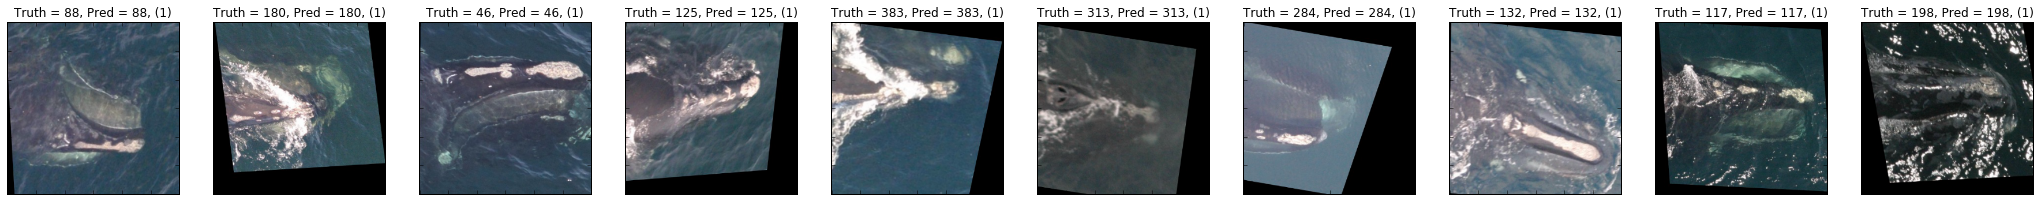

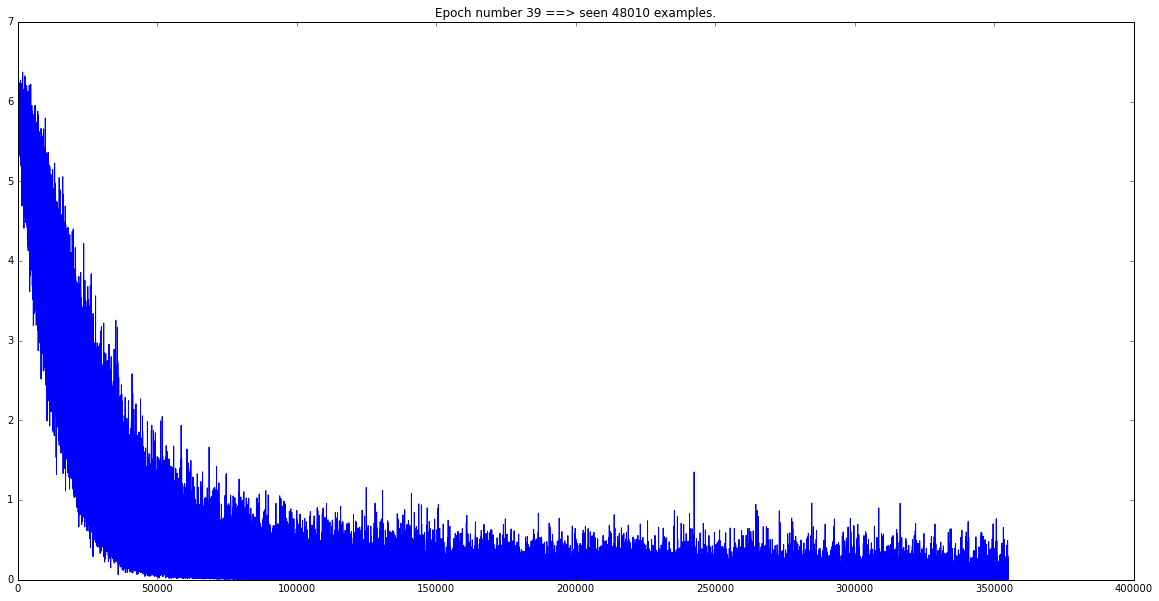

 56%|█████▌    | 5024/8984 [15:25<12:03,  5.48it/s]


KeyboardInterrupt: 

In [3]:
if __name__ == "__main__":
    nIterationsTr = trObs/batchSize
    nIterationsTe = teObs/batchSize
    trLosses = []
    teLosses = []
    for epoch in xrange(nEpochs):
        
        print("Training epoch number {0}".format(epoch)) ############################## TRAIN ################################
        if epoch > 0:
            load = 1 # Must have a model to load by 2nd epoch... so load it !
            tf.reset_default_graph()
        x, y, yPaths, yPred, ce, correct, accuracy, trainStep, learningRate = nodes("train")
        saver = tf.train.Saver()
        df = trainCsv
        with tf.Session() as sess:
            if load == 1:
                saver.restore(sess,modelName)
            else:    
                init = tf.initialize_all_variables()
                sess.run(init)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess,coord=coord)
            count = 0
              
            for i in tqdm(xrange(nIterationsTr)):
                _, loss_, x_, y_,yPred_, yPaths_ = sess.run([trainStep, ce, x, y, yPred, yPaths],feed_dict={learningRate:lr})
                trLosses.append(loss_)
                count += x_.shape[0]
                if i % 300 == 0:
                    clear_output()
                    displayBatch(x_,decodeLabel(y_.argmax(1)),decodeLabel(yPred_.argmax(1)))
                    plt.title("Epoch number {0} ==> seen {1} examples.".format(epoch,count))
                    trLossesT = np.array(trLosses)
                    plt.plot(trLossesT)
                    plt.show()

            if epoch % 3 == 0 and epoch >0:
                #lr /= 2.0 
                print("learning rate now = {0}".format(lr))
            saver.save(sess,modelName) 
            sess.close()    
   
        if trainAll == False:
            print("Testing epoch number {0}".format(epoch)) ############################## TEST ################################
            tf.reset_default_graph()
            x, y, yPaths, yPred, ce, correct, accuracy = nodes("test")
            saver = tf.train.Saver()
            df = testCsv
            with tf.Session() as sess:
                saver.restore(sess,modelName)
                coord = tf.train.Coordinator()
                threads = tf.train.start_queue_runners(sess=sess,coord=coord)
                count = 0
                for i in tqdm(xrange(nIterationsTe)):
                    loss_, x_, y_,yPred_, yPaths_ = sess.run([ce, x, y, yPred, yPaths])
                    teLosses.append(loss_)
                    count += x_.shape[0]
                    if i == nIterationsTe-1:
                        clear_output()
                        displayBatch(x_,decodeLabel(y_.argmax(1),testCsv),decodeLabel(yPred_.argmax(1),testCsv))
                        plt.title("Test epoch number {0} ==> seen {1} examples.".format(epoch,count))
                        teLossesT = np.array(teLosses)
                        plt.plot(teLossesT)
                        plt.show()
                sess.close()
            
        if epoch+1 == nEpochs:
            plt.subplot(121)
            plt.plot(trLossesT)
            plt.subplot(122)
            plt.plot(teLossesT)
            plt.show()